<a href="https://colab.research.google.com/github/ortizjeison/assessment/blob/main/src/assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Scientist Assessment Test

**Introducción.**

Melonn es una compañía que ofrece una solución integral en logística para sus clientes, gracias a la plataforma tecnológica que le permite monitorear cada etapa del proceso:desde la recepción de la orden hasta la entrega al consumidor final.

![title](https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F8b5323b1-f43d-40dd-b27d-d251c5788c20%2FUntitled.png?table=block&id=b1fc4d42-b191-4b87-803a-2a9db2c4edd8&spaceId=c322e442-fbdf-440c-b851-332ee5a4c1c9&width=2000&userId=77e451ba-6807-48ce-9790-936e16f436a3&cache=v2)


Se cuenta con un dataset que alberga el histórico de órdenes desde 2018-01-01 hasta 2021-02-28, en formato csv, con los siguientes campos:

* OrderId: Identificador de orden.
* RequestTime: Marca de tiempo en la que fue recibida la orden.
* DeliveryOption: La opción de envío seleccionada por el operador.



Para abordar este proyecto, se propone el siguiente proceso:

![process](https://raw.githubusercontent.com/ortizjeison/assessment/main/process.png)


---


# 1.   Entender el problema
El entendimiento del problema implica de entrada tener claras las reglas del negocio, el proceso y cómo se relacionan. Al ser un problema logístico, es vital analizar la situación en función del tiempo.

Es por esto que se diseñó una línea de tiempo que interrelaciona la mayoría de las entidades y procesos del sistema, entre ellos a los operadores y sus horarios de trabajo, los horarios de entrega y de disponibilidad de opciones de envío, entre otros.

![title](https://raw.githubusercontent.com/ortizjeison/assessment/main/Imagen1.png)

Este diagrama permite revisar una a una las reglas de negocio y entender cómo éstas se relacionan con los procesos de negocio.

Así pues, se puede fijar el objetivo del proyecto:

Diseñar y construir un modelo predictivo que permita estimar cuántos operadores (pickers) por cada turno son necesarios para cubrir la demanda de órdenes en el siguiente mes.


# 2.   Extracción de datos.

En este escenario, no es necesario realizar el proceso de extracción, ya que el dataset aprovisionado, cuenta con las columnas necesarias para desarrollar el proyecto.



In [112]:
import pandas as pd
from pandas import Series
import plotly.express as px
from datetime import datetime
from dateutil import parser
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

rcParams['figure.figsize'] = 20,5

#This is mainly business logic to determinate which Shift will be in charge of the order
def setShift(Time,Option):
  parsedTime = datetime.strptime(str(Time).split(" ")[1], "%H:%M:%S")
  startTime = datetime.strptime("8:00:00", "%H:%M:%S")
  endTime = datetime.strptime("18:00:00", "%H:%M:%S")

  if(Option==1 and parsedTime >= startTime and parsedTime <= endTime):
    #Today Shift B (12:00pm - 6:00pm)
    return 'B'
  elif(Option==2 and parsedTime >= startTime and parsedTime <= endTime):
    #Next Day Shift A (6:00am - 12:00pm)
    return 'A'
  elif(Option==3 and parsedTime >= startTime and parsedTime <= endTime):
    #Next Day Shift A (6:00am - 12:00pm)
    return 'A'
  else:
    return np.nan

# 3.   Limpieza de datos

Para este proceso, fue necesario realizar una primera inspección a alto nivel de los datos. Dado que esta técnica no es del todo confiable, se utilizaron algunas funciones de python que permiten tener un primer acercamiento a la calidad de los datos en términos de conteos, registros únicos, etc.

De allí se puede observar que no hay datos NaN o registros duplicados, lo cual permitirá pasar a la siguiente etapa del proceso sin necesidad de tomar ninguna acción de limpieza.

In [114]:
labeledDF = pd.read_csv('https://raw.githubusercontent.com/ortizjeison/assessment/main/data/raw/Datos_Prueba_DataScientist.csv')
labeledDF.describe()
print(labeledDF.isna().sum())

OrderId           0
RequestTime       0
DeliveryOption    0
dtype: int64


# 4.   Análisis Exploratorio de datos

Antes de proceder a explorar los datos, resulta necesario realizar algunos ajustes en el dataframe para facilitar el análisis y posterior procesamiento de los datos para implementar el modelo predictivo.

EL primero de ellos consiste en reemplazar los strings de la columna DeliveryOption, este es un paso opcional, ya que bien podrían compararse strings.

El segundo ajuste consiste en crear una columna **Shift** y asignando el valor correspondiente en cada fila, por lo cual se creó la función *setShift*, lo cual permite también validar que los datos de las órdenes cumplen con dichas reglas.

Finalmente se ajusta la estructura del dataframe, se indica la columna **RequestTime** como la columna de índices y para revalidar, se eliminan los registros duplicados y NaN, aún sabiendo que el dataset original no cuenta con este tipo de registros.

Finalmente se implementa la función info del dataframe para revisar el conteo de los registros, cantidad de nulos y tipos de datos.

En esta etapa del proceso vale la pena emplear herramientas de visualización, pero decide posponerse a la etapa de modelación ya que se simplifica notablemente la interpretación de dichos gráficos con el tipo de modelamiento que se quiere implementar.

In [ ]:
#Replace Strings
labeledDF = labeledDF.applymap(lambda x: str(x.replace('Mismo dia entre 6:30 pm y 8:30 pm','1')))
labeledDF = labeledDF.applymap(lambda x: str(x.replace('Siguiente dia entre 12:30 pm y 2:30 pm','2')))
labeledDF = labeledDF.applymap(lambda x: str(x.replace('Siguiente dia entre las 6:30 pm y 8:30 pm','3')))

#Set appropiated data types
labeledDF["DeliveryOption"] = pd.to_numeric(labeledDF["DeliveryOption"])
labeledDF['RequestTime'] = pd.to_datetime(labeledDF['RequestTime'])

#Create Shift Column using our previously created function
labeledDF['Shift'] = labeledDF.apply(lambda row: setShift(row.RequestTime,row.DeliveryOption), axis=1)

#Set RequestTime as dataframe index
labeledDF.index = labeledDF['RequestTime']
del labeledDF['RequestTime']
labeledDF.drop_duplicates()
labeledDF.dropna()

labeledDF.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 153275 entries, 2018-01-01 08:03:12 to 2021-02-28 17:53:41
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   OrderId         153275 non-null  object
 1   DeliveryOption  153275 non-null  int64 
 2   Shift           153275 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.7+ MB


# 5.   Selección de características

Después de analizar los datos de entrada con el resultado esperado del modelo, se encuentra que la entidad que más relevancia tiene son los turnos (Shifts), ya que relacionan a los pickers con la demanda y finalmente porque permiten determinar cuántos pickers deben contratarse. 

Así pues, el objetivo consiste en predecir cuál será la demanda en términos del turno A (6am-12pm) y del turno B (12pm-6pm). Cabe anotar que, según las reglas de negocio, la contratación se realiza mensualmente para cada uno de los turnos, es por esto que la resolución de los datos se trabajará en intervalos mensuales.


---



# 6.   Implementación de modelos

La metodología a implementar consiste en dividir el dataset en dos conjuntos, uno para cada Turno y computando los datos de forma mensual, esto con el fin de predecir cada uno de los turnos de forma independiente, ya que desde el punto de vista del negocio, se puede inferir que son afectados únicamente por los niveles de demanda.

Posteriormente se graficarán los datos mensuales en función del tiempo para determinar su estructura de forma visual para así empezar a analizar qué modelo predictivo podría ser implementado.

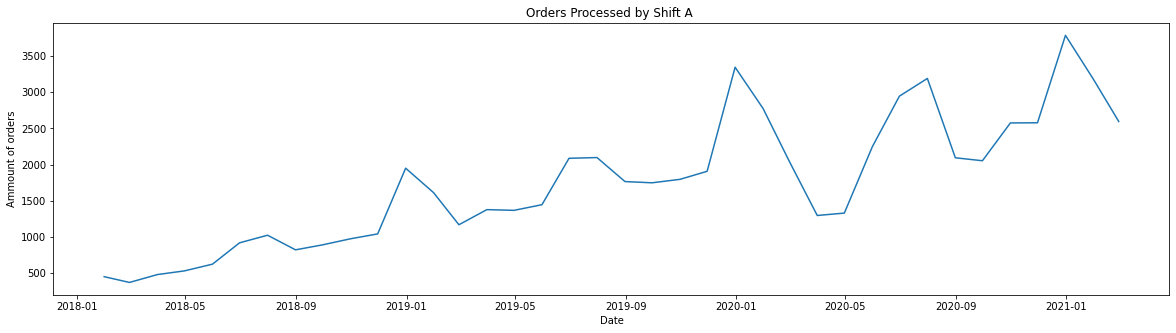

In [ ]:
shiftA = labeledDF.query("Shift == 'A'")
shiftA = shiftA.groupby(level=0).count()
del shiftA['OrderId']
del shiftA['DeliveryOption']

shiftA = shiftA.resample('M').sum()
plt.plot(shiftA)
plt.title("Orders Processed by Shift A ")
plt.ylabel("Ammount of orders")
plt.xlabel("Date")
plt.show()

Dado que se presume que los datos tienen una tendencia lineal y cumplen con cierta estacionalidad, se descomponen permitiéndonos encontrar que el gráfico Residual muestra bastante ruido con muchas fluctuaciones alrededor del 0, esto podría atribuirse en parte (no exclusivamente) a la afectación que se conoce debido a la pandemia. Por otra parte se visualiza una tendencia creciente y un comportamiento de estacionalidad claro.

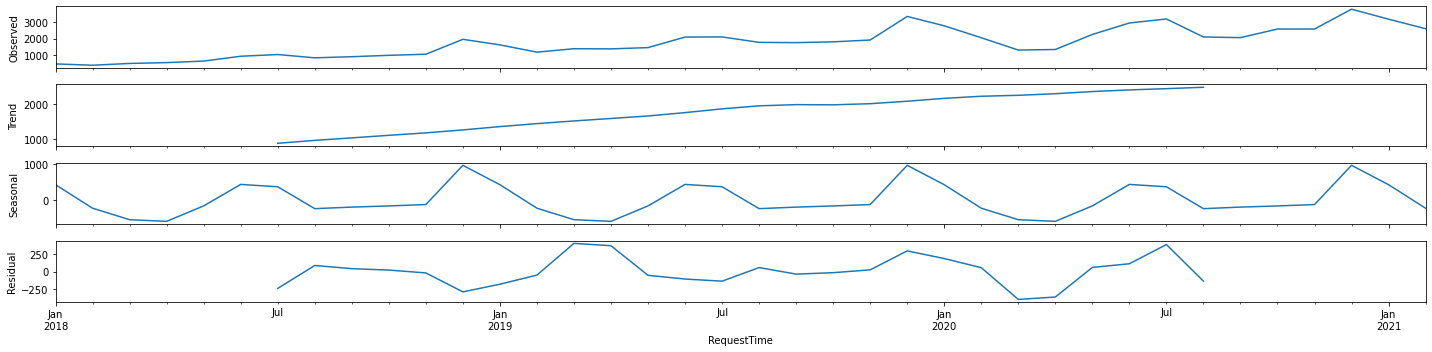

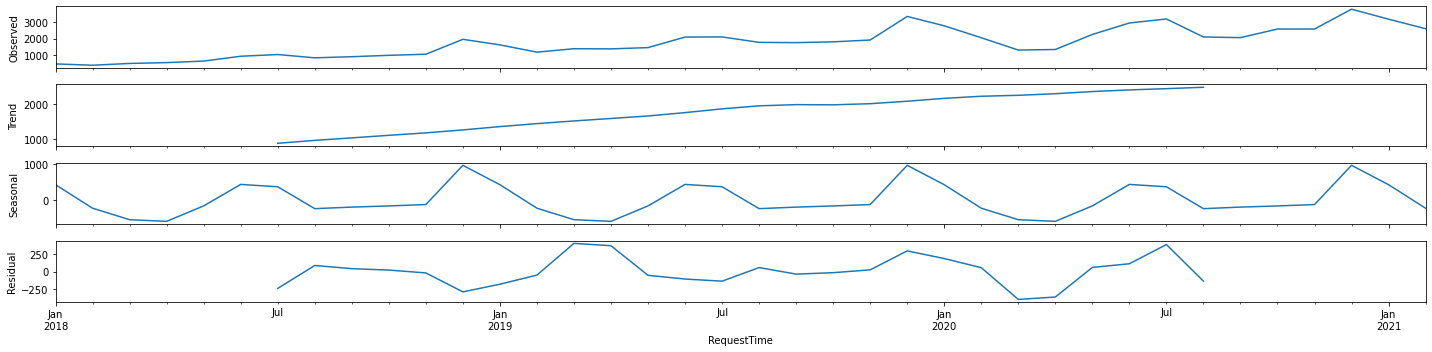

In [ ]:
result = seasonal_decompose(shiftA['Shift'], model='additive')
result.plot()

El modelo elegido en este caso es un SARIMA, ya que es un método para el pronóstico de series de tiempo con datos univariados que contienen tendencias y estacionalidad que es lo que hemos podido evidenciar en este caso.

los parámetros de orden fueron obtenidos de forma iterativa implementando el modelo y revisando la métrica AIC buscando ajustar un modelo más óptimo.

In [ ]:
model=sm.tsa.statespace.SARIMAX(shiftA['Shift'],order=(2, 2, 2),seasonal_order=(0,1,0,12))
results=model.fit()

Posteriormente se realiza la predicción con el modelo y se grafican los datos del Turno A (en línea azul) junto a la predicción de los 6 siguientes meses (en línea roja), es decir, desde marzo hasta agosto del 2021.

count       6.000000
mean     2550.821884
std       735.648408
min      1727.618063
25%      1956.634100
50%      2490.850917
75%      3096.473031
max      3518.702508
dtype: float64


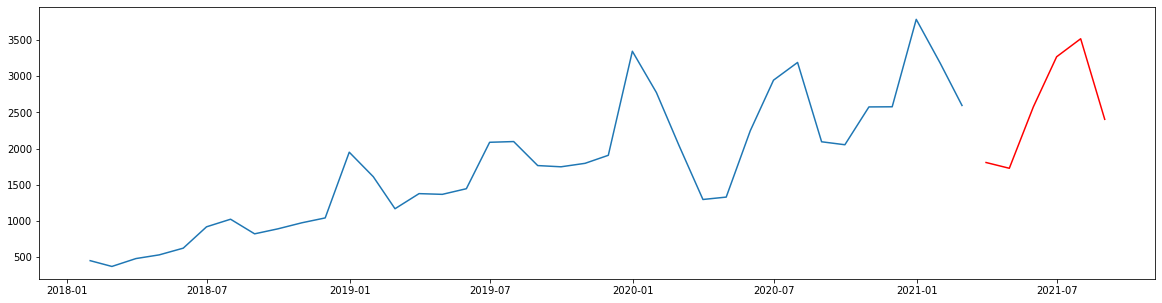

2021-03-31    1807.354536
2021-04-30    1727.618063
2021-05-31    2577.229041
2021-06-30    3269.554361
2021-07-31    3518.702508
2021-08-31    2404.472792
Freq: M, dtype: float64

In [ ]:
forecastShiftA=results.predict(start=len(shiftA),end=len(shiftA)+5,dynamic=True)

plt.plot(shiftA['Shift'])
plt.plot(forecastShiftA, color='red')
plt.show()

forecastShiftA

# 6.   Prueba de modelos

Para probar los modelos se implementó inicialmente un modelo ARIMA y se compararon varias versiones con el modelo SARIMA aquí presentado, el cual muestra un AIC de 361.597, del cual se puede inferir que la calidad de la predicción es superior comparado a los ARIMA.

Al revisar el gráfico de residuos puede observarse muchos picos que dejan abierta la posibilidad de implementar modelos más óptimos.

                                 Statespace Model Results                                 
Dep. Variable:                              Shift   No. Observations:                   38
Model:             SARIMAX(2, 2, 2)x(0, 1, 0, 12)   Log Likelihood                -175.799
Date:                            Mon, 02 May 2022   AIC                            361.597
Time:                                    05:08:54   BIC                            367.487
Sample:                                01-31-2018   HQIC                           363.160
                                     - 02-28-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6555      0.281      2.331      0.020       0.104       1.207
ar.L2         -0.5775      0.272   

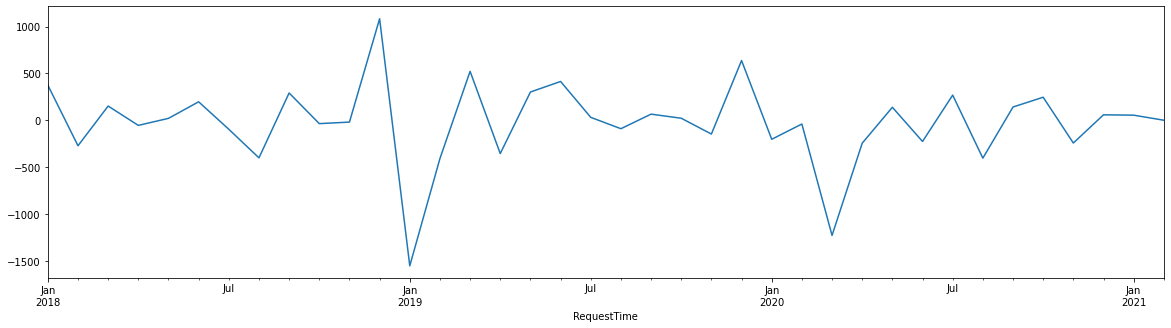

In [ ]:
print(results.summary())
results.resid.plot()

De forma similar, se realiza el mismo proceso de modelamiento para el turno B (Esta vez obviando las gráficas y los resúmenes, pues se ha comprobado que tienen un comportamiento muy similar)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


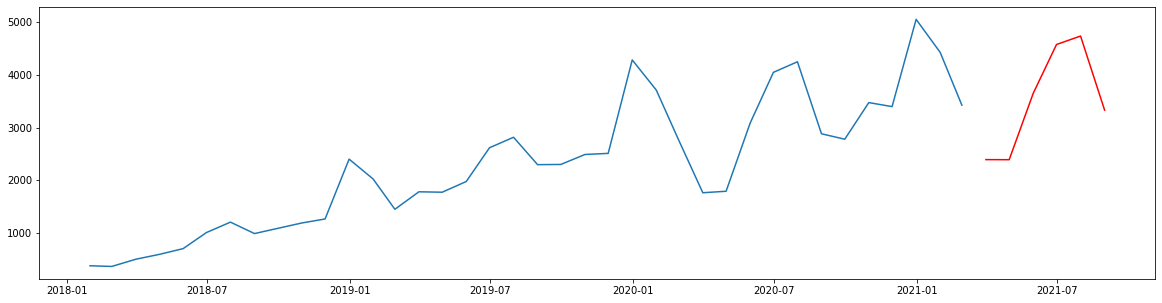

2021-03-31    2390.775979
2021-04-30    2389.065178
2021-05-31    3649.900562
2021-06-30    4575.788253
2021-07-31    4736.194436
2021-08-31    3330.409063
Freq: M, dtype: float64

In [ ]:
shiftB = labeledDF.query("Shift == 'B'")
shiftB = shiftB.groupby(level=0).count()
del shiftB['OrderId']
del shiftB['DeliveryOption']

shiftB = shiftB.resample('M').sum()

result = seasonal_decompose(shiftB['Shift'], model='additive')
model=sm.tsa.statespace.SARIMAX(shiftB['Shift'],order=(2, 2, 2),seasonal_order=(0,1,0,12))
results=model.fit()

forecastShiftB=results.predict(start=len(shiftB),end=len(shiftB)+5,dynamic=True)
plt.plot(shiftB['Shift'])
plt.plot(forecastShiftB, color='red')
plt.show()

forecastShiftB

También es de interés identificar si existe una correlación entre el nivel de afectación debido a la pandemia del COVID con la demanda en cada uno de los turnos.

Allí se encuentra que existe una correlación positiva de un caracter entre bajo y moderado, lo cual no parece ser muy determinante e invita a explorar otros métodos de análisis.

In [ ]:
level = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,1,1,1,2,2,1,1,2,2,1]

shiftACovid = shiftA.copy()
shiftACovid = shiftACovid.assign(Affectedness=level)

shiftBCovid = shiftB.copy()
shiftBCovid = shiftBCovid.assign(Affectedness=level)

print(shiftACovid['Shift'].corr(shiftACovid['Affectedness']))
print(shiftBCovid['Shift'].corr(shiftBCovid['Affectedness']))

0.3831131626803294
0.41244670414477796


# Resultados

Luego de tener cada uno de los turnos pronosticados, se procede a calcular la cantidad de pickers que deberían ser contratados para el mes siguiente, es decir, marzo del 2021.

Cabe anotar que se indica que cada operador debe tener una carga de trabajo mínima de 5 órdenes por hora y se asume que es esta relación empleada durante el turno, el cual al durar 6 horas indica que cada operador puede encargarse de 30 órdenes por turno. Por lo tanto, se tomará la demanda esperada y se dividirá por 31 (número de días en un mes) para calcular la demanda diaria. Finalmente se dividirá esa demanda diaria por las 5 órdenes que puede procesar cada picker, obteniendo así la cantidad de pickers requerida.

In [ ]:
forecastB = forecastShiftB.to_frame()
forecastB.set_axis(["Orders"],axis=1,inplace=True)
forecastB["Pickers Shift B"] = forecastB.applymap(lambda x: np.ceil((x/31)/5))

forecastA = forecastShiftA.to_frame()
forecastA.set_axis(["Orders"],axis=1,inplace=True)
forecastA["Pickers Shift A"] = forecastA.applymap(lambda x: np.ceil((x/31)/5))

print('Pickers Shift A (6am-12pm): %d' % (forecastA['Pickers Shift A'].iloc[0]))
print('Pickers Shift B (12pm-6pm): %d' % (forecastB['Pickers Shift B'].iloc[0]))

Pickers Shift A (6am-12pm): 12
Pickers Shift B (12pm-6pm): 16


# Conclusiones y recomendaciones

Si bien de forma gráfica el ajuste propuesto muestra un ajuste aceptable, se  ha detectado mucho ruido, el cual afecta sin duda alguna el rendimiento del modelo.


Para futuras iteraciones del proyecto, vale la pena explorar modelos basados en deep learning para realizar este tipo de estimaciones o bien, un modelo similar al aquí propuesto pero autoajustado que pueda aportar un mejor desempeño.


Es útil definir una función que permita validar las reglas de negocio, en términos de la mantenibilidad del modelo.


Los efectos de la pandemia, pese a ser cuantificados en un nivel de 0 a 3 podrían tomarse en consideración si se aportan más detalles de cómo fue calculado o realizar un modelo adicional que evalúe qué impacto tiene en la demanda.